In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.functional import F
from torchvision.transforms import functional
import random
import torch.optim as optim
from tqdm.notebook import tqdm
import torchvision
from time import time
import torch.optim.lr_scheduler as S
import math
import random
import matplotlib.pyplot as plt
import numpy as np

In [22]:
torch.cuda.is_available()

True

In [23]:
device = 'cuda'

test_set = torchvision.datasets.MNIST(root = 'data/', train = False, download = True)
test_input = test_set.data.view(-1, 1, 28, 28).float().to(device)
test_targets = test_set.targets.to(device)

mu, std = test_input.mean(), test_input.std()
test_input.sub_(mu).div_(std)

train_set = torchvision.datasets.MNIST(root = 'data/', train = True, download = True)
train_input = train_set.data.view(-1, 1, 28, 28).float()
train_targets = train_set.targets

In [24]:
class mLeNet(nn.Module):
    def __init__(self, use_bn=False):
        super(mLeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding = 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        last_channel = 16
        self.conv3 = nn.Conv2d(16, last_channel, 2)
        self.use_bn = use_bn
        if self.use_bn:
            self.conv1_bn = nn.BatchNorm2d(6)
            self.conv2_bn = nn.BatchNorm2d(16)
            self.conv3_bn = nn.BatchNorm2d(last_channel)

        self.fc3 = nn.Linear(last_channel, 10)

    def forward(self, x):
        if self.use_bn:
            x = F.max_pool2d(F.relu(self.conv1_bn(self.conv1(x))), 2)
            x = F.max_pool2d(F.relu(self.conv2_bn(self.conv2(x))), 2)
            x = F.max_pool2d(F.relu(self.conv3_bn(self.conv3(x))), 2)
        else:
            x = F.max_pool2d(F.relu(self.conv1(x)), 2)
            x = F.max_pool2d(F.relu(self.conv2(x)), 2)
            x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.adaptive_avg_pool2d(x,1)
        x = torch.flatten(x, 1)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
def train_model(use_bn = False, lr = 0.005, optimize_method = torch.optim.SGD, seed = 0, momentum = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    device = 'cuda'
    nb_epochs, batch_size = 3000, 32

    model = mLeNet(use_bn = use_bn)
    model.to(device)
    optimizer = optimize_method(model.parameters(), lr = lr, momentum = momentum )
    criterion = nn.CrossEntropyLoss()
    scheduler = S.StepLR(optimizer, step_size=200, gamma=1)

    train_len, attack_len = 512, 512
    lbd = 0.2

    test_acc = []
    train_acc = []
    l_list = []

    criterion.to(device)

    train_x, train_y = train_input[:train_len].to(device), train_targets[:train_len].to(device)
    mu, std = train_x.mean(), train_x.std()
    train_x.sub_(mu).div_(std)

    attack_x, attack_y = train_input[train_len:train_len + attack_len].to(device), train_targets[train_len:train_len + attack_len].to(device)
    mu, std = attack_x.mean(), attack_x.std()
    attack_x.sub_(mu).div_(std)

    mylist = list(range(10))
    for i in range(attack_len):
        n = mylist[:]
        n.remove(attack_y[i])
        attack_y[i] = random.choice(n)


    train_batches = math.ceil(train_len/batch_size)

    for e in tqdm(range(nb_epochs)):
        ite = 0
        for input, targets in zip(train_x.split(batch_size) + attack_x.split(batch_size),train_y.split(batch_size) + attack_y.split(batch_size)):
        
        #for input, targets in zip(train_x.split(batch_size),train_y.split(batch_size)):
            output = model(input)
            ite += 1
            if ite<=train_batches:
                loss = criterion(output, targets)
            else:
                loss = lbd*criterion(output, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        with torch.no_grad():
            out = model(train_x)
            _, predicted_classes = out.max(1)
            _, predicted_classes_test = model(test_input).max(1)

            l = criterion(out, train_y).item()
            test_a = (predicted_classes_test == test_targets).to(float).mean().item()
            train_a = (predicted_classes == train_y).to(float).mean().item()

            l_list.append(l)
            test_acc.append(test_a)
            train_acc.append(train_a)
            
            if (e>=500) and (all(i >= 2 for i in l_list[-10:])):
                return model,"diverge"
                break
            
            print("epoch: %i, loss: %.4f, train_acc: %.4f, test_acc: %.4f" %(e+1,l,train_a,test_a))
            stats = [e+1,l,train_a,test_a]
            if l <= 0.001:
                return model,stats
                break
    return model,stats

In [26]:
def H_fro_approx(model, use_bn = False, seed = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    device = 'cuda'
    train_len = 512

    train_x, train_y = train_input[:train_len].to(device), train_targets[:train_len].to(device)
    mu, std = train_x.mean(), train_x.std()
    train_x.sub_(mu).div_(std)
    m_up = mLeNet(use_bn = use_bn).to(device)
    m_down = mLeNet(use_bn = use_bn).to(device)
    criterion = nn.CrossEntropyLoss()
    criterion.to(device)
    eps = 1e-5
    M=100
    diffs = torch.zeros(M)
    for i in range(M):
        m_up.zero_grad()
        m_down.zero_grad()
        for po,p_up,p_down in zip(model.parameters(),m_up.parameters(),m_down.parameters()):
            temp = torch.normal(0,1,size=po.shape).to(device)
            p_up.data = po + eps*temp
            p_down.data = po - eps*temp
            #print(p_up.shape,p_down.shape)

        loss_up = criterion(m_up(train_x), train_y)
        loss_up.backward()

        loss_down = criterion(m_down(train_x), train_y)
        loss_down.backward()


        grad_up = []
        grad_down = []

        nparams = 0
        for p_up,p_down in zip(m_up.parameters(),m_down.parameters()):
            grad_up.append(p_up.grad.view(-1).data)
            grad_down.append(p_down.grad.view(-1).data)
            
        diffs[i] = ((torch.concat(grad_up)-torch.concat(grad_down))**2).sum()

    return (diffs.sum()/(4*M*eps*eps)).sqrt().item()

In [29]:
optimize_method = torch.optim.SGD
use_bn = True
lr = 0.2
stats_data = np.empty([3,20],dtype=object)
Hessians = np.empty([3,20],dtype=object)
momentum_list = [0,0.3,0.6]
for seed in range(20):
    for ii,momentum in enumerate(momentum_list):
        print(momentum,seed)
        my_model,stats_data[ii,seed] = train_model(use_bn = use_bn, lr = lr, optimize_method = optimize_method, seed = seed, momentum = momentum)
        Hessians[ii,seed] = H_fro_approx(my_model,use_bn = use_bn, seed = seed)
        print(Hessians[ii,seed])
        np.save("experiment_results/hessians_mo.npy",Hessians)
        np.save("experiment_results/stats_data_mo.npy",stats_data)

0 0


  0%|          | 0/3000 [00:00<?, ?it/s]

epoch: 1, loss: 2.1295, train_acc: 0.2988, test_acc: 0.2425
epoch: 2, loss: 2.0863, train_acc: 0.3516, test_acc: 0.2485
epoch: 3, loss: 1.8449, train_acc: 0.5625, test_acc: 0.4149
epoch: 4, loss: 2.0268, train_acc: 0.2773, test_acc: 0.2207
epoch: 5, loss: 1.8010, train_acc: 0.3906, test_acc: 0.3319
epoch: 6, loss: 2.0121, train_acc: 0.2715, test_acc: 0.1868
epoch: 7, loss: 1.9343, train_acc: 0.3594, test_acc: 0.2491
epoch: 8, loss: 1.9886, train_acc: 0.3164, test_acc: 0.2076
epoch: 9, loss: 1.9388, train_acc: 0.3262, test_acc: 0.2177
epoch: 10, loss: 1.8570, train_acc: 0.3945, test_acc: 0.2528
epoch: 11, loss: 1.9474, train_acc: 0.3340, test_acc: 0.2085
epoch: 12, loss: 2.0847, train_acc: 0.2148, test_acc: 0.1235
epoch: 13, loss: 1.8019, train_acc: 0.3652, test_acc: 0.2078
epoch: 14, loss: 1.7852, train_acc: 0.3828, test_acc: 0.2235
epoch: 15, loss: 1.6544, train_acc: 0.4609, test_acc: 0.2751
epoch: 16, loss: 1.7720, train_acc: 0.3691, test_acc: 0.2057
epoch: 17, loss: 1.6604, train_ac

KeyboardInterrupt: 

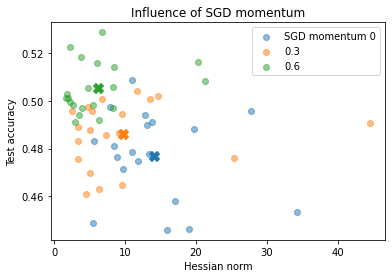

In [20]:
hessians_mo = np.load("experiment_results/hessians_mo.npy", allow_pickle=True)
stats_data_mo = np.load("experiment_results/stats_data_mo.npy", allow_pickle=True)
labels_mo = ["SGD momentum 0", "0.3", "0.6"]

hessian_mean = []
test_acc_mean = []

for mo_index in range(len(labels_mo)):
    hessian_list = []
    test_acc_list = []
    for ii, stat in enumerate(stats_data_mo[mo_index]):
        if type(stat) == str:
            continue
        if (stat[0]<3000 or stat[1]<=0.0015) and hessians_mo[mo_index,ii] < 100:
            test_acc_list.append(stat[-1])
            hessian_list.append(hessians_mo[mo_index,ii])
    plt.scatter(hessian_list,test_acc_list,label = labels_mo[mo_index],alpha=0.5)
    hessian_mean.append(np.mean(hessian_list))
    test_acc_mean.append(np.mean(test_acc_list))

plt.gca().set_prop_cycle(None)

for mo_index in range(len(labels_mo)):
    plt.scatter(hessian_mean[mo_index],test_acc_mean[mo_index], marker="X", s=100)
    
plt.legend()
plt.xlabel('Hessian norm')
plt.ylabel('Test accuracy')
plt.title('Influence of SGD momentum')
plt.savefig("figures/momentum.png",dpi=200,bbox_inches='tight')